In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

### Fetch data from nerd sqlite database

In [2]:
def fetch_fit_params(db_path, fit_kind, selected_construct_names, selected_temperature):
    """
    Fetch fit parameters from the database for a given fit kind, construct name, and temperature.
    
    Parameters
    ----------
    fit_kind : str
        Kind of fit to filter by.
    selected_construct_name : str
        Construct name to filter by (e.g., '4U_wt').
    selected_temperature : int
        Temperature to filter by (e.g., 25).
    
    Returns
    -------
    pd.DataFrame
        DataFrame containing the fit parameters.
    """

    conn = sqlite3.connect(db_path)

    placeholders = ", ".join([f":construct_{i}" for i in range(len(selected_construct_names))])
    params = {
        "fit_kind": fit_kind,
        "temperature": selected_temperature,
        **{f"construct_{i}": name for i, name in enumerate(selected_construct_names)},
    }

    fit_params_df = pd.read_sql_query(
        f"""
        SELECT
            log_kobs,
            log_kdeg,
            r2,
            nt_base,
            nt_site,
            construct_name,
            rg_id
        FROM probe_tc_fits_view
        WHERE fit_kind = :fit_kind
        AND construct_name IN ({placeholders})
        AND temperature = :temperature
        """,
        conn,
        params=params,
    )

    conn.close()

    return fit_params_df

### Main function definition and execution

In [3]:
NERD_SQLITE = '../../../Core_nerd_analysis/nerd.sqlite'

# Fetches all reps for 4U_wt at 25C
df = fetch_fit_params(
    db_path=NERD_SQLITE,
    fit_kind='round3_constrained', # Constrained for global kdeg
    selected_construct_names = ['4U_wt'],
    selected_temperature = 25,
)

#exclude rg_id 10, outlier
df = df[~df['rg_id'].isin([10, 32])]

# Melt dataframe for seaborn plot
df_melted = df.melt(id_vars=['nt_base', 'nt_site', 'construct_name'], value_vars=['log_kobs', 'log_kdeg', 'r2'], var_name='parameter', value_name='value')

# Sort by base (only A and C)
bases = ['A', 'C']
df_melted['nt_base'] = pd.Categorical(df_melted['nt_base'], categories=bases, ordered=True)

#### Swarm plot for $R^2$

In [4]:
r2_toplot = df_melted[df_melted['parameter'] == 'r2']

r2_toplot

,nt_base,nt_site,construct_name,parameter,value
168,NaN,5,4U_wt,r2,-1.774803e-12
169,NaN,6,4U_wt,r2,9.590996e-01
170,A,7,4U_wt,r2,9.911894e-01
171,A,8,4U_wt,r2,9.912916e-01
172,C,9,4U_wt,r2,9.945173e-01
...,...,...,...,...,...
247,NaN,27,4U_wt,r2,5.449323e-01
248,NaN,28,4U_wt,r2,4.585537e-01
249,NaN,30,4U_wt,r2,7.633664e-01
250,NaN,31,4U_wt,r2,6.714726e-01


/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


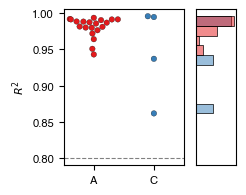

Number of R2 > 0.8: 24 out of 24
Percentage of R2 > 0.8: 100.00%


In [5]:
# Filter for r2 only
r2_toplot = df_melted[df_melted['parameter'] == 'r2']
r2_toplot.to_csv('swarmplot_r2_data.csv')

# Swarmplot for r2
fig, axs = plt.subplots(1, 2, figsize=(2.5, 2), sharey = True, gridspec_kw={'width_ratios': [3, 1]})
sns.swarmplot(data=r2_toplot, x='nt_base', y='value', hue='nt_base', palette = 'Set1', dodge = False, size = 4, edgecolor = 'k', linewidth = 0.2, ax = axs[0])
axs[0].axhline(0.8, color='gray', linestyle='--', linewidth=0.8)
axs[0].set_xlabel('')
axs[0].set_ylabel(r'$R^2$')
# remove legend from axs[0]
axs[0].get_legend().remove()

# Plot histogram on axs[1]
sns.histplot(data=r2_toplot, y='value', hue='nt_base', palette = 'Set1', bins = 10, stat='proportion', linewidth = 0.5, common_norm=False, kde = False, alpha = 0.5, ax = axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('swarmplot_r2_rd3_AC_4U_25C.pdf')
plt.show()

# Count how many R2 > 0.8 in total
r2_toplot = r2_toplot.dropna(subset=['nt_base'])
r2_high = r2_toplot[r2_toplot['value'] > 0.8]
r2_high_count = r2_high.shape[0]
r2_total_count = r2_toplot.shape[0]
print(f'Number of R2 > 0.8: {r2_high_count} out of {r2_total_count}')
print(f'Percentage of R2 > 0.8: {r2_high_count / r2_total_count * 100:.2f}%')

#### Swarm plot for $\ln (k_{text{obs}})$

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_87894/2220020197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logkobs_toplot['kobs'] = np.exp(logkobs_toplot['value'])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


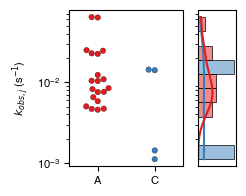

In [6]:
# Filter for log_kobs only
logkobs_toplot = df_melted[df_melted['parameter'] == 'log_kobs']
logkobs_toplot['kobs'] = np.exp(logkobs_toplot['value'])
logkobs_toplot.to_csv('swarmplot_kobs_data.csv')

# Swarmplot for log_kobs
fig, axs = plt.subplots(1, 2, figsize=(2.5, 2), sharey = True, gridspec_kw={'width_ratios': [3, 1]})
sns.swarmplot(data=logkobs_toplot, x='nt_base', y='kobs', hue='nt_base', palette = 'Set1', dodge = False, size = 4, edgecolor = 'k', linewidth = 0.2, ax = axs[0], log_scale=True)
axs[0].set_xlabel('')
axs[0].set_ylabel(r'$k_{obs,j}$ (s$^{-1}$)')
axs[0].get_legend().remove()

# plot histogram on axs[1]
sns.histplot(data=logkobs_toplot, y='kobs', hue='nt_base', palette = 'Set1', bins = 10, stat='proportion', linewidth = 0.5, common_norm=False, kde = True, alpha = 0.5, ax = axs[1], log_scale=True)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('swarmplot_lnkobs_rd3_AC_4U_25C.pdf')
plt.show()